Plan:
- [x] Read the article
- [] Repeat it hear
- [] Reread what was written
- [] Integrate article about two fish bites
- [] Do necessary refactoring if needed

Link to the article from habrahabr (in russian): https://habr.com/ru/post/557424/

In [1]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams

rcParams['figure.figsize'] = 10, 6

In [2]:
sns.set_style("whitegrid")

Let's image that during the whole year we ordered pizza and measured time of delivery each time.

In [3]:
norm_rv = stats.norm(loc=30, scale=5)

In [4]:
np.random.seed(42)
samples = norm_rv.rvs(365)
samples = np.trunc(samples)
samples[:50]

array([32., 29., 33., 37., 28., 28., 37., 33., 27., 32., 27., 27., 31.,
       20., 21., 27., 24., 31., 25., 22., 37., 28., 30., 22., 27., 30.,
       24., 31., 26., 28., 26., 39., 29., 24., 34., 23., 31., 20., 23.,
       30., 33., 30., 29., 28., 22., 26., 27., 35., 31., 21.])

Of course we want to take a look at the min, max, mean and std values.

In [5]:
print(min(samples))
print(max(samples))
print(samples.mean())
print(samples.std())

13.0
49.0
29.52054794520548
4.77410133275075


In other words we can say that average time of delivery is $30 \pm 5$ minutes.

Also it might be interesting to see how values are distributed.

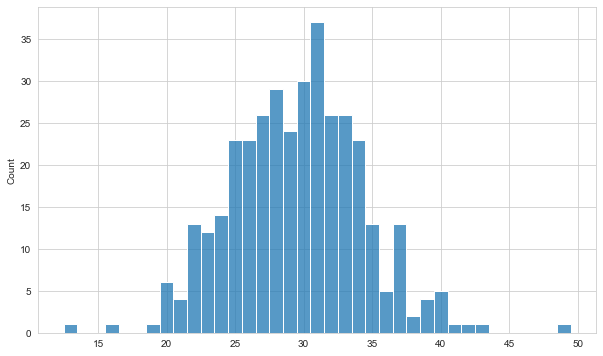

In [6]:
sns.histplot(samples, discrete=True);

By looking at this chart we can easily assume that time delivery can have normal distribution. But why we decided that it has normal distribution? Because this histogram looks similar to normal distribution probability density plot? If we are talking about visual acceptance then we can easily build a chart from other distribution that will look also similar to the histogram above.

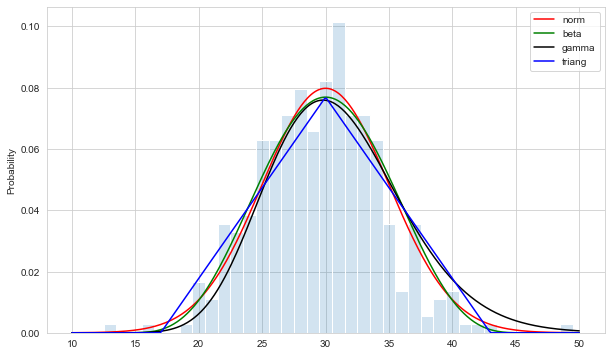

In [7]:
np.random.seed(42)
norm_rv = stats.norm(loc=30, scale=5)
beta_rv = stats.beta(a=5, b=5, loc=14, scale=32)
gamma_rv = stats.gamma(a = 20, loc = 7, scale=1.2)
tri_rv = stats.triang(c=0.5, loc=17, scale=26)

x = np.linspace(10, 50, 300)

sns.lineplot(x = x, y = norm_rv.pdf(x), color='r', label='norm')
sns.lineplot(x = x, y = beta_rv.pdf(x), color='g', label='beta')
sns.lineplot(x = x, y = gamma_rv.pdf(x), color='k', label='gamma')
sns.lineplot(x = x, y = tri_rv.pdf(x), color='b', label='triang')

sns.histplot(x=samples, discrete=True, stat='probability',
             alpha=0.2);

Are we sure that the distribution is normal?

The process of delivery might trigger multiple situations:
- wait at the stop sign for the green light
- injured leg so walked slower than usual
- car didn't want to start
- and so on

For us doesn't matter what are these situations, we only care that they are independent and have uniform distribution.

For example take variable $X_{1}$ which describes time spent at the stop sign. It has uniform distribution and ranges from 0 up to 4 minutes.

In [8]:
uniform_rv = stats.uniform(loc=0, scale=4)

In [9]:
np.random.seed(42)
uniform_rv.rvs(size=1)

array([1.49816048])

And tomorrow, after-tomorrow and after-after-tomorrow in might be:

In [10]:
np.random.seed(42)
uniform_rv.rvs(size=3)

array([1.49816048, 3.80285723, 2.92797577])

Now let's imagine that there are 15 of such variables and each introduces it's own value into overall delivery time because such events can be added to each other. 

If you imagined total 15 variables: $X_{1}, X_{2}, ... ,X_{15},$, then we can say that total delivery time consist of sum of these variables and this delivery time is also random variable which we can assign to letter $Y$:

$$ Y = X_{1} + X_{2} + ... + X_{15} = \sum_{i=1}^{15}X_{i} $$

If all variable values ($X_{1}, X_{2}, ... ,X_{15},$) are distributed uniformly then how would be distributed their sum - variable $Y$? 

In order to find out let's generate 10k such sums and take a look at the histogram:

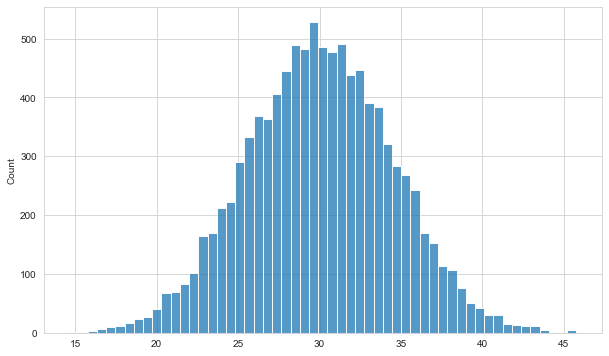

In [11]:
np.random.seed(42)
Y_samples = [uniform_rv.rvs(size=15).sum() for _ in range(10_000)]
sns.histplot(x=Y_samples);

Does this picture remind you the same bell as in normal distribution? If so, then you've just understood central limit theory: distribution of sum of random variables moves towards normal distribution with the increase of the number of variables in that sum.

Of course that example with pizza delivery is not exactly wright as all situations might occur or might not. 

For example time of delivery for today consist of these variables:

$$ Y = X_{3} + X_{5} + X_{7} + X_{11} $$ 

And tomorrow it might be:

$$ Y = X_{1} + X_{3} + X_{9} + X_{10} + X_{13} + X_{15}$$ 

Will be $Y$ distributed normally? Well, considering that sum of normally distributed variables also has normal distribution than we can say yes. This is exactly why when we took a look at the distribution of 365 samples of delivery we almost immediately decided that this is normal distribution despite it doesn't look like perfect bell. 

## Z-values

Imaging that after a year of our measurements we've got a new neighbor and also decided to order pizza daily. After three days we became a victim of an argument between our neighbor and pizza delivery guy. We tried to support delivery guy and said that on average time of delivery is $30 \pm 5$ minutes. Our neighbor said that he order pizza three time and all three times delivery took more than 40 minutes which is definitely longer than 35 minutes.  

Why our neighbor is so confident in long time of deliver? It looks like he thinks that $30 \pm 5$ minutes means that delivery can take 27, 31 or even 35 minutes but not 23 or 38 minutes. But we've ordered pizza 365 times and know that delivery time can take somewhere in between 17 and 44 minutes. And $30 \pm 5$ just means that some major portion of deliveries will take from 25 to 35 minutes. 

Knowing parameters of the distribution we can generate couple of thousands of deliveries and find out the size of that majority delivery portion.

In [12]:
N = 5_000
np.random.seed(42)
t_data = norm_rv.rvs(N)
t_data[(25 < t_data) & (t_data < 35)].size / N

0.6874

Approximately two thirds of all generated deliveries are in range between 25 and 35 minutes. How many deliveries took more than 40 minutes?  

In [13]:
t_data[t_data > 40].size / N

0.0224

It turns out that slightly more than 2 percent of generated deliveries took more than 40 minutes. But our neighbor said that he delivered 3 times in a row and all of them took more than 40 minutes. Maybe our neighbor is extremely unlucky because probability of it is very low: 

In [14]:
0.02 ** 3

8.000000000000001e-06

Of course computer modeling is all good and what not but in this case it's better to use $Z$-values:

$$ Z = \frac{y - \mu}{\sigma} $$

where:
- $y$: delivery time, in other words some exact value from random variable $Y$
- $\mu$: mathematical expectancy
- $\sigma$: standard deviation

So let's calculate $Z$-value for 40 minutes delivery:

$$ Z = \frac{40 - 30}{5} = 2$$

What we have just done? We've just calculated by what value our delivery time differs from average delivery time and then just divided by value of standard deviation. But how to understand the result of this calculation and what does $Z$-value means? 

In order to understand it we need to "draw" a little bit.

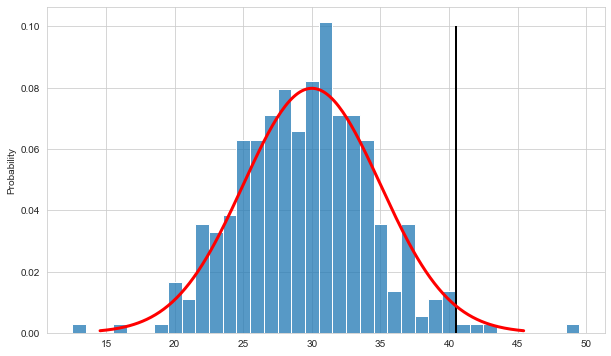

In [15]:
fig, ax = plt.subplots()
x = np.linspace(norm_rv.ppf(0.001), norm_rv.ppf(0.999), 200)
ax.vlines(40.5, 0, 0.1, color='k', lw=2)
sns.lineplot(x=x, y=norm_rv.pdf(x), color='r', lw=3)
sns.histplot(x=samples, stat='probability', discrete=True);

At this chart we plotted histogram from our `samples` data, but now height of each square means not the quantity of each values but probability of it. With red line we plotted function of distribution of probability density of delivery values. 

Above we tried to by experimental approach to decide what portion of measurements take deliveries with time more than 40 minutes. And this chart should give us some thoughts that there are two approaches of solving this task. The first one is experimental, we generate for example 5k deliveries and then build histogram and calculate sum of rectangles that lay to the right from black line: 

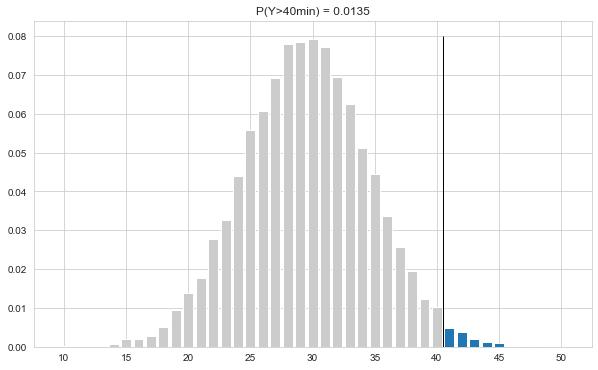

In [16]:
np.random.seed(42)
N = 10000
values = np.trunc(norm_rv.rvs(N))

fig, ax = plt.subplots()
v_le_41 = np.histogram(values, np.arange(9.5, 41.5))
v_ge_40 = np.histogram(values, np.arange(40.5, 51.5))
ax.bar(np.arange(10, 41), v_le_41[0]/N, color='0.8')
ax.bar(np.arange(41, 51), v_ge_40[0]/N)
p = np.sum(v_ge_40[0]/N)
ax.set_title('P(Y>40min) = {:.3}'.format(p))
ax.vlines(40.5, 0, 0.08, color='k', lw=1);

The other approach - analytic. As we know that delivery times are from normal distribution then we can use function of distribution of probability density. This function is good because the area underneath it is always equals to 1 and if we are interested in probability of value that is higher or lower of given value we can simply take the are under the function that is to the right or to the left of that given value.

For example we can calculate and plot probability of delivery time that take more than 40 minutes like so:

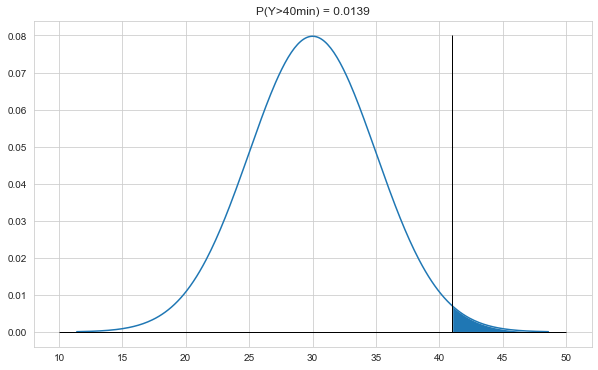

In [17]:
fig, ax = plt.subplots()

x = np.linspace(norm_rv.ppf(0.0001), norm_rv.ppf(0.9999), 300)
ax.plot(x, norm_rv.pdf(x))

ax.fill_between(x[x>41], norm_rv.pdf(x[x>41]), np.zeros(len(x[x>41])))
p = 1 - norm_rv.cdf(41)
ax.set_title('P(Y>40min) = {:.3}'.format(p))
ax.hlines(0, 10, 50, lw=1, color='k')
ax.vlines(41, 0, 0.08, color='k', lw=1);

Ok, let's imaging that we are on some island and we found out that average height of hobbits and gnomes in centimeters is distributed as $N(91;8^2)$ and $N(134;6^2)$ respectively. If Frodo's height is 99 centimeters and Gimli's is 143 centimeters then how to decided which height is more typical to their kinds? In order to find out we can plot function of distribution of probability density, mark their heights and measure portion of those whose height is higher than Frodo or Gimli.

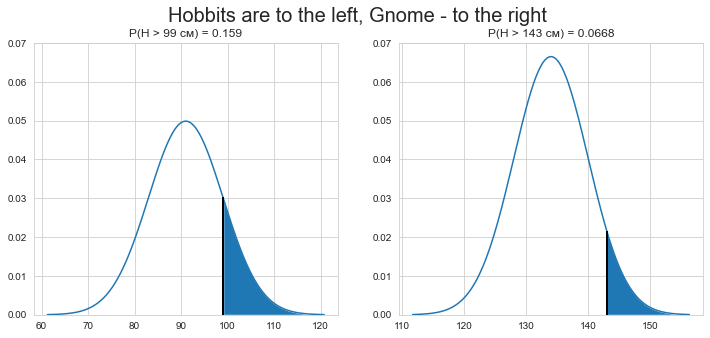

In [18]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (12, 5))

nrv_hobbit = stats.norm(91, 8)
nrv_gnome = stats.norm(134, 6)

for i, (func, h) in enumerate(zip((nrv_hobbit, nrv_gnome), (99, 143))):
    x = np.linspace(func.ppf(0.0001), func.ppf(0.9999), 300)
    ax[i].plot(x, func.pdf(x))
    ax[i].fill_between(x[x>h], func.pdf(x[x>h]), np.zeros(len(x[x>h])))
    p = 1 - func.cdf(h)
    ax[i].set_title('P(H > {} см) = {:.3}'.format(h, p))
    ax[i].hlines(0, func.ppf(0.0001), func.ppf(0.9999), lw=1, color='k')
    ax[i].vlines(h, 0, func.pdf(h), color='k', lw=2)
    ax[i].set_ylim(0, 0.07)
fig.suptitle('Hobbits are to the left, Gnome - to the right', fontsize = 20);

By looking at these charts we can assume that Frodo's height is more typical than Gimli's as it is closer to the pick of the distribution. That means that it's more likely to find hobbit with the height the same as Frodo than to meat a gnome with height the same as Gimli. That is what `typicality` means.

Performing comparison is much more easy if to use $Z$-values:

$$ Z_{Frodo} = \frac{99 - 91}{8} = 1 $$
$$ Z_{Gimli} = \frac{143 - 134}{6} = 1 $$

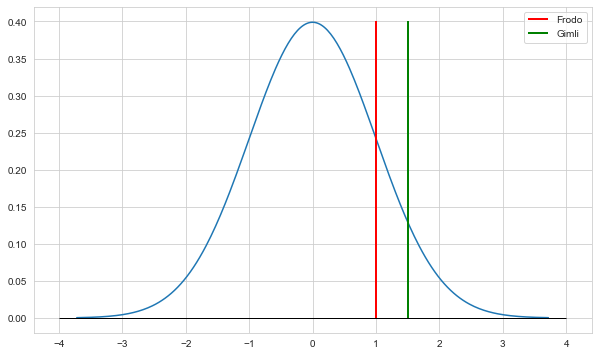

In [19]:
fig, ax = plt.subplots()
N_rv = stats.norm()
x = np.linspace(N_rv.ppf(0.0001), N_rv.ppf(0.9999), 300)
ax.plot(x, N_rv.pdf(x))
ax.hlines(0, -4, 4, lw=1, color='k')
ax.vlines(1, 0, 0.4, color='r', lw=2, label='Frodo')
ax.vlines(1.5, 0, 0.4, color='g', lw=2, label='Gimli')
ax.legend();

Huge advantage of $Z$-values is that they are standardized, in other words they are transformed in such way like they are taken from normal distribution $N(0;1)$, both have mean of 0 and std of 1, that's why we were able to plot them at the same chart. 

Even without plotting chart we can find out which height is more typical by comparing absolute values:

$$ | Z_{Frodo} | < | Z_{Gimli} | $$

values with smaller absolute $Z$-value are more typical.

Comparison of multiple $Z$-values from multiple normal distributions is possible because $Z$-values are measured in $\sigma$ units. It becomes apparent when we take a look at the formula one more time:

$$ Z = \frac{y - \mu}{\sigma} $$

It doesn't matter what we are trying to compare: height, weight or income; whatever original units are, after calculating $Z$-values they are all will be measure in $\sigma$ units. The smaller absolute $Z$-value is the closer it is to the peak of the distribution and the sign of $Z$-value wil show to what side of this peak this value is located. 

## Z-statistics

Let's get back to our neighbor that is very upset by long delivery of pizza. Above we calculated $Z$-value for 40 minutes delivery:

$$ Z = \frac{40 - 30}{5} = 2 $$

Right now we don't have enough experience do figure out is it a lot or not so let's draw a chart first:

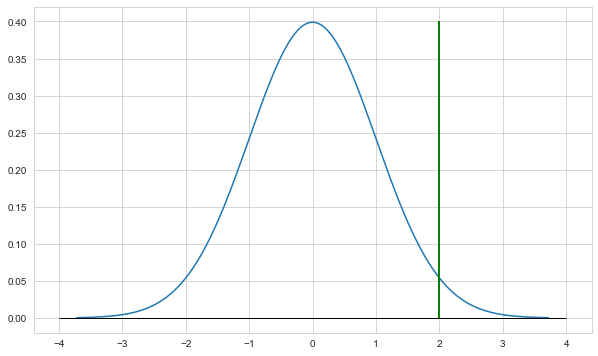

In [20]:
np.random.seed(42)
fig, ax = plt.subplots()
N_rv = stats.norm()
x = np.linspace(N_rv.ppf(0.0001), N_rv.ppf(0.9999), 300)
ax.plot(x, N_rv.pdf(x))
ax.hlines(0, -4, 4, lw=1, color='k')
ax.vlines(2, 0, 0.4, color='g', lw=2);

This value is in $2\sigma$ distance away from the peak which is quite a lot actually. But our neighbor says that he weighted for 40 minutes 3 times in a row. 3 values is a statistics.

Characteristics of general population is called parameters and characteristics of a sample - statistics. By measuring delivery time during 365 days we made an assumption about parameters of general distribution, in other words about all possible delivery times, decided that those values are taken from normal distribution with parameters $N(30;5^2)$. By knowing that we can make some experiments. For example our neighbor made only three orders and by his assumption all three took more than 40 minutes. What if we repeat this experiment 5k times and will take a look at the distribution of the average of 3 orders:

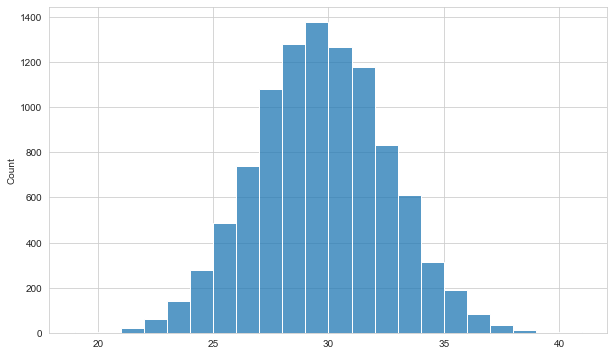

In [21]:
sns.histplot(np.trunc(norm_rv.rvs(size=(N, 3))).mean(axis=1), bins=np.arange(19, 42));

Judging by the chart we can see that to get average delivery time more than 40 minutes is very unlikely. 

We can have two explanations:
- either our neighbor is lying
- or something wrong with the general population; perhaps for some reason delivery is changed and now it takes more time then before

Measured $Z$-value for 40 minutes delivery ($Z$ = 2) allows us to calculate probability to get values more than 40: 

In [22]:
1 - N_rv.cdf(2)

0.02275013194817921

That's why it's unsurprising that probability of getting average time of 3 ordered more than 40 minutes is extremely low:

In [23]:
(1 - N_rv.cdf(2)) ** 3

1.1774751750476762e-05

In [24]:
f"{((1 - N_rv.cdf(2)) ** 3):.10f}"

'0.0000117748'

In [25]:
f"{((1 - N_rv.cdf(2)) ** 3 * 100):.10f}"

'0.0011774752'

If with $Z$-value we can measure each value separately, then in order to measure probability of an average of multiple values we need to use $Z$-statistics:

$$ Z = \frac{\bar{x} - \mu}{\frac{\sigma}{\sqrt{n}}} $$

where:
- $\bar{x}$: average of our sample
- $\mu$: average value of general population
- $\sigma$: standard deviation of general population
- $n$: size of the sample

Let's now imaging that we made three orders and average value is 25 minutes, then $Z$-statistics will look like this:

$$ Z = \frac{35-30}{\frac{5}{\sqrt{3}}} \approx 1.73 $$

$Z$-statistics as like $Z$-value measures in units of standard deviation and it lets us to use standard normal distribution for calculation of probabilities. In fact we trying to ask a question  what is the probability of the average of three deliveries in be in range:

$$ \left[ \mu - | \mu - \bar{x} |; \mu + | \mu - \bar{x} | \right] $$

which is in our case looks like $\left[25;35\right]$ minutes.

As like before we can calculate such probability with probability modeling:

In [26]:
np.random.seed(42)

N = 10_000
orders = norm_rv.rvs(size=(N, 3))
orders = np.trunc(orders)
means = orders.mean(axis=1)

means[(25 <= means) & (means <= 35)].size / N

0.9243

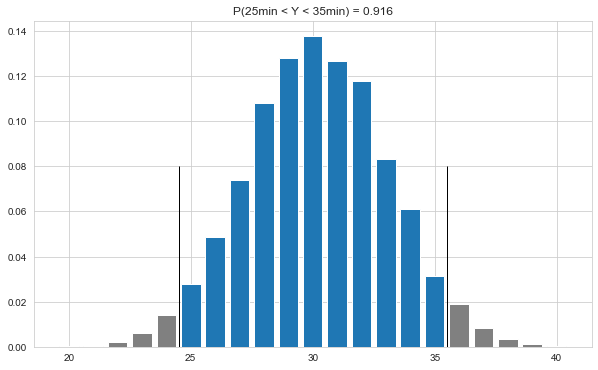

In [27]:
np.random.seed(42)

N = 10_000
fig, ax = plt.subplots()
means = np.trunc(norm_rv.rvs(size=(N, 3))).mean(axis=1)
h = np.histogram(means, np.arange(19, 41))
ax.bar(np.arange(20, 25), h[0][0:5]/N, color='0.5')
ax.bar(np.arange(25, 36), h[0][5:16]/N)
ax.bar(np.arange(36, 41), h[0][16:22]/N, color='0.5')
p = np.sum(h[0][6:16]/N)
ax.set_title('P(25min < Y < 35min) = {:.3}'.format(p))
ax.vlines([24.5 ,35.5], 0, 0.08, color='k', lw=1);

From the other hand we can calculate the same probability with analytics approach:

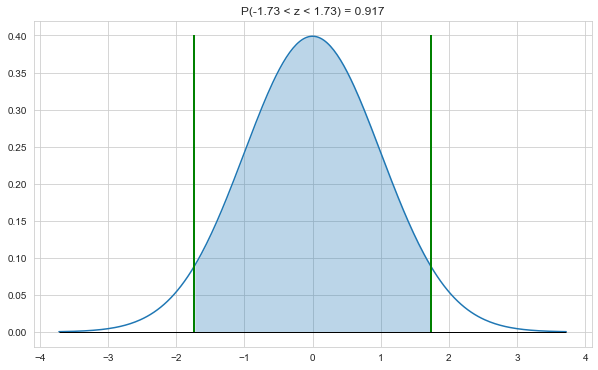

In [28]:
x, n, mu, sigma = 35, 3, 30, 5
z = abs((x - mu)/(sigma/n**0.5))

N_rv = stats.norm()
fig, ax = plt.subplots()
x = np.linspace(N_rv.ppf(0.0001), N_rv.ppf(0.9999), 300)
ax.plot(x, N_rv.pdf(x))
ax.hlines(0, x.min(), x.max(), lw=1, color='k')
ax.vlines([-z, z], 0, 0.4, color='g', lw=2)
x_z = x[(x>-z) & (x<z)] # & (x<z)
ax.fill_between(x_z, N_rv.pdf(x_z), np.zeros(len(x_z)), alpha=0.3)

p = N_rv.cdf(z) - N_rv.cdf(-z)
ax.set_title('P({:.3} < z < {:.3}) = {:.3}'.format(-z, z, p));

Take a look that $Z$-statistics depends not only on average of the sample $\bar{x}$ but also on the size of the sample $n$. If we order pizza 5, 30 or even 100 times, then what probability that an average of those orders will be in range $\left[29;31\right]$? Let's take a look:

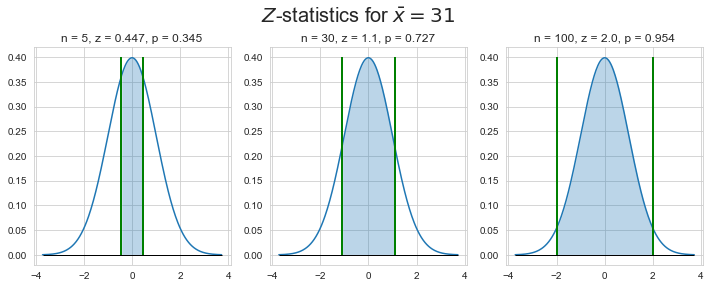

In [29]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize = (12, 4))

for i, n in enumerate([5, 30, 100]):
    x, mu, sigma = 31, 30, 5
    z = abs((x - mu)/(sigma/n**0.5))

    N_rv = stats.norm()
    x = np.linspace(N_rv.ppf(0.0001), N_rv.ppf(0.9999), 300)
    ax[i].plot(x, N_rv.pdf(x))
    ax[i].hlines(0, x.min(), x.max(), lw=1, color='k')
    ax[i].vlines([-z, z], 0, 0.4, color='g', lw=2)
    x_z = x[(x>-z) & (x<z)] # & (x<z)
    ax[i].fill_between(x_z, N_rv.pdf(x_z), np.zeros(len(x_z)), alpha=0.3)

    p = N_rv.cdf(z) - N_rv.cdf(-z)
    ax[i].set_title('n = {}, z = {:.3}, p = {:.3}'.format(n, z, p));
fig.suptitle(r'$Z$-statistics for $\bar{x} = 31$', fontsize = 20, y=1.02);

With 5 orders an average of the sample will be in range $\left[29;31\right]$ most likely because of pure luck. With 30 orders about a quoter of averages will not be in the range. And only with 100 of orders we can be more or less sure that deviation of the sample's average from general population's average will not be more than 1 minute.

From the other hand we can think about it differently: if general population's average is equal to 30 minutes, what is the probability of getting sample's average if we order 5, 30 or 100 orders? It's obvious that with 5 orders average of the sample will deviate quite a lot, which means that probability of obtaining $\bar{x}$ is quite high. But with 100 orders average of the sample almost don't deviate from the average of general population, that's why it's unlikely to obtain $\bar{x}$ with $n$=100. 
What does it mean? It means that if we order 100 pizzas and get sample's average of 31 minutes, then either we a wrong that average of the general population is equal to 30 minutes.

What to do with our neighbor that ordered only 3 pizzas? Is he right? Looks like it, yes. Even if his average delivery time is 40 minutes, $Z$-statistics is 3.81 and the area under the curve will be almost equal to 1.

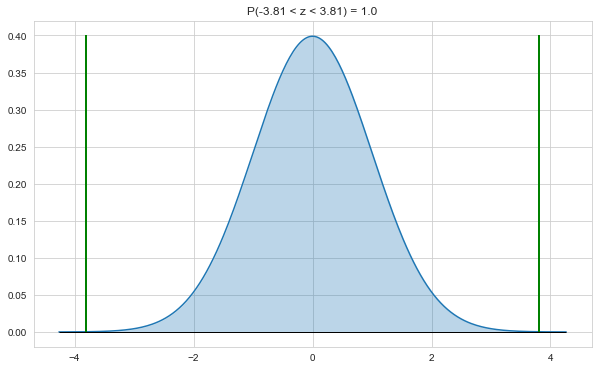

In [30]:
x, n, mu, sigma = 41, 3, 30, 5
z = abs((x - mu)/(sigma/3**0.5))

N_rv = stats.norm()
fig, ax = plt.subplots()
x = np.linspace(N_rv.ppf(1e-5), N_rv.ppf(1-1e-5), 300)
ax.plot(x, N_rv.pdf(x))
ax.hlines(0, x.min(), x.max(), lw=1, color='k')
ax.vlines([-z, z], 0, 0.4, color='g', lw=2)
x_z = x[(x>-z) & (x<z)] # & (x<z)
ax.fill_between(x_z, N_rv.pdf(x_z), np.zeros(len(x_z)), alpha=0.3)

p = N_rv.cdf(z) - N_rv.cdf(-z)
ax.set_title('P({:.3} < z < {:.3}) = {:.3}'.format(-z, z, p));

That means that probability of obtaining random variable that deviates from general distribution with $\mu$=30 and $\sigma$=5 by more than 10 minutes is extremely low. In this case we can assume that:
- either our neighbor is very unlucky person
- or pizza delivery is changed and now take more time then before

What variant has higher probability? Most likely our neighbor is right about long delivery time.

## $P$-value

We saw that $Z$-statistics gives us possibility to measure likelihood of average of sample $\bar{x}$ with size $n$ taken from general distribution will be in given range. That's useful and lets us to make assumption of randomness of obtained $\bar{x}$. The lower absolute value of $Z$-statistics the lower likelihood of correctness of the average. 

For example previously we saw that probability of $\bar{x}$ with $n$=5 will be in range $\left[29;31\right]$ is about only 0.35. While probability of not be in that range is $1-0.35=0.65$. That's why we've made conclusion that $\bar{x}$=31 and $n$=5 is more like random, rather than something systematic. 

In fact value of 0.65, that we've obtained earlier, is $p$-value and it shows probability of being out of range of interval, that is set by values of $Z$-statistics:

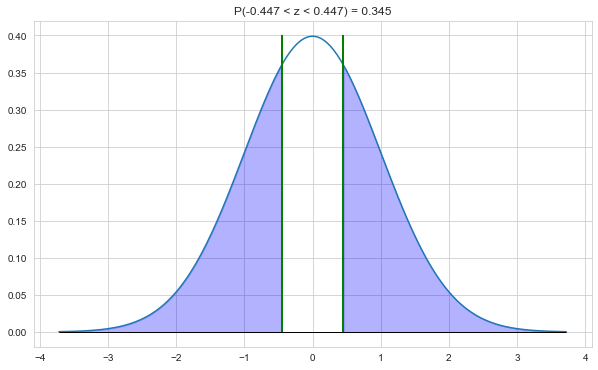

In [31]:
x, n, mu, sigma = 31, 5, 30, 5
z = abs((x - mu)/(sigma/n**0.5))
N_rv = stats.norm()
fig, ax = plt.subplots()
x = np.linspace(N_rv.ppf(0.0001), N_rv.ppf(0.9999), 300)
ax.plot(x, N_rv.pdf(x))
ax.hlines(0, x.min(), x.max(), lw=1, color='k')
ax.vlines([-z, z], 0, 0.4, color='g', lw=2)
x_le_z, x_ge_z = x[x<-z], x[x>z]
ax.fill_between(x_le_z, N_rv.pdf(x_le_z), np.zeros(len(x_le_z)), alpha=0.3, color='b')
ax.fill_between(x_ge_z, N_rv.pdf(x_ge_z), np.zeros(len(x_ge_z)), alpha=0.3, color='b')

p = N_rv.cdf(z) - N_rv.cdf(-z)
ax.set_title('P({:.3} < z < {:.3}) = {:.3}'.format(-z, z, p));

The bigger $p$-value is the higher probability of the average of sample being random. At the same time $p$-value is tightly connected with two-side hypothesis, hypothesis that value is in the range. If we get some result, but $p$-value is relatively big, then this result we can treat as not valuable. 

Traditionally that threshold is assigned to $\alpha$ and has value of 0.05, and that means that for accepting any $p$-value it has to be lower than $\alpha$=0.05. At the same time it worth mentioning that $\alpha$=0.05 might not be acceptable in some researches. For example for research in area of education $\alpha$=0.1 might be sufficient, while in quantum physics we might reduce $\alpha$ value to $\pm5\sigma$ which is equal to:

In [32]:
1 - (N_rv.cdf(5) - N_rv.cdf(-5))

5.733031438470704e-07

In [33]:
f"{1 - (N_rv.cdf(5) - N_rv.cdf(-5)):.10f}"

'0.0000005733'

We need to not forget that acceptance score determined not only by the average of the sample, but also by it's size. If we have got multiple value that are highly unlikely for general population then it's a reason for being skeptical. 

For example our neighbor might have measured delivery time with his clocks but their battery might fail and that's cause long perceived time delivery. Such mistakes with gathering data is quite popular. But if there are no issues with gathering data then we can increase sample size in order to be sure. For example our neighbor might have ordered couple pizzas more and only after that start complaining.

From the other hand in order to prove small deviations from general deviations we need to increase size of sample significantly. For example if we want to say with acceptance score $\alpha=0.05$ that average delivery time is equal to 31 and 30 as we claimed before, we need to make at least 100 orders.

## Central limit theory

By the way I totally forgot to say that $Z$-statistics uses central limit theory: no matter what distribution general population has distribution of it's averages will be closer to normal distribution with the increase of the size of samples.

In order to prove that let's generate 1k samples from uniform, exponential and Laplace distributions and plot kde charts for each sample size:

In [34]:
%matplotlib notebook

In [38]:
import matplotlib.animation as animation

fig, axes = plt.subplots(nrows=2, ncols=3, figsize = (12, 7))

unif_rv = stats.uniform(loc=10, scale=10)
exp_rv = stats.expon(loc=10, scale=1.5)
lapl_rv = stats.laplace(loc=15)

np.random.seed(42)
unif_data = unif_rv.rvs(size=1000)
exp_data = exp_rv.rvs(size = 1000)
lapl_data = lapl_rv.rvs(size=1000)

title = ['Uniform', 'Exponential', 'Laplace']
data = [unif_data, exp_data, lapl_data]
y_max = [60, 310, 310]
n = [3, 10, 30, 50]

for i, ax in enumerate(axes[0]):
    sns.histplot(data[i], bins=20, alpha=0.4, ax=ax)
    ax.vlines(data[i].mean(), 0, y_max[i], color='r')
    ax.set_xlim(10, 20)
    ax.set_title(title[i])

def animate(i):
    for ax in axes[1]:
        ax.clear()
    for j in range(3):
        rand_idx = np.random.randint(0, 1000, size=(1000, n[i]))
        means = data[j][rand_idx].mean(axis=1)
        sns.kdeplot(means, ax=axes[1][j])
        axes[1][j].vlines(means.mean(), 0, 2, color='r')
        axes[1][j].set_xlim(10, 20)
        axes[1][j].set_ylim(0, 2.1)
        axes[1][j].set_title('n = ' + str(n[i]))
    fig.set_figwidth(15)
    fig.set_figheight(8)
    return axes[1][0], axes[1][1],axes[1][2]
    
dist_animation = animation.FuncAnimation(fig, 
                                      animate, 
                                      frames=np.arange(4),
                                      interval = 200,
                                      repeat = False)
dist_animation.save('dist_means.gif',
                 writer='imagemagick', 
                 fps=1)


<IPython.core.display.Javascript object>

/Users/andreiaksionov/.pyenv/versions/3.10.3/envs/data-science-theory/lib/python3.10/site-packages/matplotlib/animation.py:889: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you have outputted the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(
MovieWriter imagemagick unavailable; using Pillow instead.


![plot](dist_means.gif)